# Used Car Price Predictor

## Purpose

Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value. 

Rusty Bargain is interested in:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training

## Table of Contents
<a href='#Data Preparation'>Data Preparation</a>

<a href='#Model Development'>Model Development</a>

<a href='#Model Analysis'>Model Analysis</a>

<a href='#Overall Conclusion'>Overall Conclusion</a>

<a id='Data Preparation'></a>
## Data Preparation

### General Data Information

Initially, a general look at the data is performed and the necessary libraries are imported. Since the target attribute is numerical, regression libraries are imported for the various machine learning models, including for gradient boosting.

In [1]:
#Import necessary libraries
import pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
import timeit
import warnings
from scipy import stats as st
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
data = pd.read_csv('/datasets/car_data.csv')

data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Mileage              354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


There are missing values present in the `VehicleType`, `Gearbox`, `Model`, `FuelType`, and `NotRepaired` attributes. These also happen to be the categorical features in the dataset.

### Missing Values

Since the missing values are all in the categorical features, they will initially be replaced with an 'unknown' value since this data will be used for all the iterations of the machine learning models, thus there will be a minimal difference in attempting to input a useful value.

In [4]:
#Fill all missing values with an unknown value
data.fillna('unknown', inplace=True)

**`NotRepaired`**

Since `NotRepaired` is intended to be a yes/no response, the values in it are converted to 1s, 0s, or 0.5s (due to the unknown responses) to change it to a numerical feature to prevent it from having to be one-hot encoded later on.

In [5]:
#This function returns a 0, 0.5, or 1 for the three options for the NotRepaired column
def NotRepairedNumbering(value):
    if value == 'yes':
        return 1
    elif value == 'no':
        return 0
    else:
        return 0.5
    
data['NotRepaired'] = data['NotRepaired'].apply(NotRepairedNumbering)

### Date Features

There are three attributes, `DateCrawled`, `DateCreated`, and `LastSeen` that are dates and times applicable to the dataset. Although these could be converted to a datetime datatype, these features are specific to information regarding the user profile posting the ad and would not be expected to have an impact on price of the vehicle, with the exception of potentially a seasonal impact which will not be evaluated as part of this project. As a result, these columns can be removed from the dataset.

In [6]:
data.drop(['DateCrawled', 'DateCreated', 'LastSeen'] , axis = 1, inplace=True)

### One-Hot Encoding

In order for several of the models (linear regression, XGBoost, etc.) to be developed, the categorical features in the dataset must be one-hot encoded (OHE) to assign a numerical value to each feature. Additionally, the categorical features are converted to the category data type to allow for model training further down the line.

It is noted that the original dataset will be maintained since several of the models (i.e., CatBoost) are able to accept the categorical data as-is.

In [7]:
#List of categorical features
categorical_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand']

#Converts data type from object to category
for feature in categorical_features:
    data[feature] = data[feature].astype('category')

#OHE categorical features
data_ohe = pd.get_dummies(data, drop_first = True)

### Dataset Separation

The original dataset, and the OHE dataset are separated into a training, validation, and testing dataset at a 3:1:1 ratio, respectively. Subsequently, each of these datasets can be separated into the features and targets, with the `Price` being the sole target. The size of each dataset is printed to verify a correct split.

In [8]:
#Splits the OHE dataset into 60% training, 40% leftover
data_train_ohe, data_valid_test_ohe = train_test_split(data_ohe, test_size = 0.4, random_state=12345)
#Splits the leftover OHE dataset into 50% validating, 50% testing for 20%/20% overall
data_valid_ohe, data_test_ohe = train_test_split(data_valid_test_ohe, test_size = 0.5, random_state=12345)

#Splits the original dataset into 60% training, 40% leftover
data_train, data_valid_test = train_test_split(data, test_size = 0.4, random_state=12345)
#Splits the leftover dataset into 50% validating, 50% testing for 20%/20% overall
data_valid, data_test = train_test_split(data_valid_test, test_size = 0.5, random_state=12345)

In [9]:
#Creates features and targets of each OHE dataset
features_train_ohe = data_train_ohe.drop(['Price'], axis=1)
target_train_ohe = data_train_ohe['Price']
print("Training Size: {}".format(features_train_ohe.shape))

features_valid_ohe = data_valid_ohe.drop(['Price'], axis=1)
target_valid_ohe = data_valid_ohe['Price']
print("Validation Size: {}".format(features_valid_ohe.shape))

features_test_ohe = data_test_ohe.drop(['Price'], axis=1)
target_test_ohe = data_test_ohe['Price']
print("Testing Size: {}".format(features_test_ohe.shape))

Training Size: (212621, 313)
Validation Size: (70874, 313)
Testing Size: (70874, 313)


In [10]:
#Creates features and targets of each original dataset
features_train = data_train.drop(['Price'], axis=1)
target_train = data_train['Price']
print("Training Size: {}".format(features_train.shape))

features_valid = data_valid.drop(['Price'], axis=1)
target_valid = data_valid['Price']
print("Validation Size: {}".format(features_valid.shape))

features_test = data_test.drop(['Price'], axis=1)
target_test = data_test['Price']
print("Testing Size: {}".format(features_test.shape))

Training Size: (212621, 12)
Validation Size: (70874, 12)
Testing Size: (70874, 12)


**Conclusion**

Now that all missing values have been resolved, the data separated into training, validation, and testing datasets, and the features and targets defined, the models can be created, trained, and analyzed.

<a id='Model Development'></a>
## Model Development

### Evaluation Criteria

The evaluation criteria for the selected models will be the root mean squared error (RMSE) metric. Various hyperparameters will be tuned for the decision tree and random forest models, as well as for the models that implement gradient boosting. A linear regression model will be trained and tested as a sanity check model due to its simplicity, which will be used to compare against the results of the other models.

Since the model training and prediction time are crucial in determining the ideal model, these two time frames will be displayed for each model iteration completed, in addition to the model's RMSE. Initially, the linear regression is trained and validated, with the RMSE for that being considered a baseline for selecting the best iteration of each type of model.

**Linear Regression**

In [12]:
#Creates a linear regression model and trains it against the OHE training dataset. The RMSE is determined from the validation dataset
lr_model = LinearRegression()

#Processing time is printed for both training and prediction
print('Training Time:')
%time lr_model.fit(features_train_ohe, target_train_ohe)
print('')
print('Prediction Time:')
%time lr_prediction = lr_model.predict(features_valid_ohe)
print('')
print('The RMSE for the linear regression model is {:.0f}.'.format(mean_squared_error(target_valid_ohe, lr_prediction)**0.5))

Training Time:
CPU times: user 18.8 s, sys: 7.9 s, total: 26.7 s
Wall time: 26.7 s

Prediction Time:
CPU times: user 132 ms, sys: 113 ms, total: 245 ms
Wall time: 199 ms

The RMSE for the linear regression model is 3146.


In [13]:
#Sets the RMSE of the linear regression model to a baseline variable for use later
baseline_RMSE = mean_squared_error(target_valid_ohe, lr_prediction)**0.5

**Decision Tree**

A decision tree model is also trained for various depths. Again, the time required to train and predict the RMSE is printed.

In [14]:
#Loops through a max_depth from 5 to 8. Calculates RMSE Score for each and prints the processing time for training and predicting
for depth in range (5,9):
    print('Decision Tree with max depth {}'.format(depth))
    dt_model = DecisionTreeRegressor(max_depth=depth, random_state=12345)
    print('Training Time:')
    %time dt_model.fit(features_train_ohe, target_train_ohe)
    print('')
    print('Prediction Time:')
    %time dt_prediction = dt_model.predict(features_valid_ohe)
    print('')
    print("The model RMSE Score: {:.0f}".format(mean_squared_error(target_valid_ohe, dt_prediction)**0.5))
    print('')

Decision Tree with max depth 5
Training Time:
CPU times: user 2.76 s, sys: 137 ms, total: 2.9 s
Wall time: 2.91 s

Prediction Time:
CPU times: user 69.7 ms, sys: 62.7 ms, total: 132 ms
Wall time: 132 ms

The model RMSE Score: 2543

Decision Tree with max depth 6
Training Time:
CPU times: user 3.32 s, sys: 112 ms, total: 3.43 s
Wall time: 3.44 s

Prediction Time:
CPU times: user 58.7 ms, sys: 75.5 ms, total: 134 ms
Wall time: 138 ms

The model RMSE Score: 2413

Decision Tree with max depth 7
Training Time:
CPU times: user 3.83 s, sys: 128 ms, total: 3.96 s
Wall time: 3.97 s

Prediction Time:
CPU times: user 65.9 ms, sys: 71.3 ms, total: 137 ms
Wall time: 137 ms

The model RMSE Score: 2299

Decision Tree with max depth 8
Training Time:
CPU times: user 4.24 s, sys: 131 ms, total: 4.37 s
Wall time: 4.48 s

Prediction Time:
CPU times: user 67 ms, sys: 66.4 ms, total: 133 ms
Wall time: 133 ms

The model RMSE Score: 2221



The decision tree models are all significantly better quality than the linear regression model while also taking a short amount of processing time for training and prediction.

### Hyperparameter Tuning

**LightGBM**

The first gradient boosting model that will be trained and tested is LightGBM. For this model, the hyperparameters of `learning_rate`, `iterations`, and `depth` are varied. In order to easily select the best hyperparameters based on the RMSE, the initial RMSE is compared to the linear regression, with the lowest RMSE being selected as the 'best' RMSE. All subsequent model RMSEs are then evaluated against the 'best' RMSE with the best RMSE and the hyperparameters required to get that RMSE printed at the end of all the model iterations. This algorithm is used for all of the hyperparameter tuning for the gradient boosting models.

The LightGBM library accepts categorical features as-is, so no modifications need done to address these.

In [20]:
#Creates tuples of the various hyperparameter combinations
LGBM_params = [(learning_rate, iterations, depth) for learning_rate in [x/2 for x in range(1, 3)] for iterations in range(50, 101, 50) for depth in range(6, 11, 2)]

#Sets initial values for the best score and parameters
best_LGBM_parameters = [0, 0, 0]
best_LGBM_RMSE = baseline_RMSE

#Loops through each combination of hyperparameters. For each combination, the training time and prediction time for the model
#is printed. RMSE is determined from the validation set
for learning_rate, iterations, depth in reversed(LGBM_params):
    print('LightGBM with learning rate: {}, n-estimators: {}, max tree depth: {}'.format(learning_rate, iterations, depth))

    LGBM_model = lgb.LGBMRegressor(learning_rate = learning_rate, n_estimators = iterations, max_depth = depth)
    
    print('Training Time:')
    %time LGBM_model.fit(features_train, target_train)
    
    print('Prediction Time:')
    %time LGBM_prediction = LGBM_model.predict(features_valid)

    print('RMSE: {:.0f}'.format(mean_squared_error(target_valid, LGBM_prediction)**0.5))
    print('')
    print('')
    #Ensures the lowest RMSE and associated hyperparameters are stored in the 'best' variables
    if mean_squared_error(target_valid, LGBM_prediction)**0.5 < best_LGBM_RMSE:
        best_LGBM_RMSE = mean_squared_error(target_valid, LGBM_prediction)**0.5
        best_LGBM_parameters = [learning_rate, iterations, depth]
        
print('The best RMSE is {:.0f}, which are from the following parameters - learning rate: {}, n-estimators: {}, max tree depth: {}'.format(best_LGBM_RMSE, best_LGBM_parameters[0], best_LGBM_parameters[1], best_LGBM_parameters[2]))

LightGBM with learning rate: 1.0, n-estimators: 100, max tree depth: 10
Training Time:
CPU times: user 1.79 s, sys: 27.3 ms, total: 1.82 s
Wall time: 1.89 s
Prediction Time:
CPU times: user 438 ms, sys: 3.55 ms, total: 441 ms
Wall time: 444 ms
RMSE: 1903


LightGBM with learning rate: 1.0, n-estimators: 100, max tree depth: 8
Training Time:
CPU times: user 1.77 s, sys: 48.6 ms, total: 1.82 s
Wall time: 1.83 s
Prediction Time:
CPU times: user 450 ms, sys: 7.9 ms, total: 457 ms
Wall time: 460 ms
RMSE: 1889


LightGBM with learning rate: 1.0, n-estimators: 100, max tree depth: 6
Training Time:
CPU times: user 1.98 s, sys: 31.1 ms, total: 2.01 s
Wall time: 2.11 s
Prediction Time:
CPU times: user 556 ms, sys: 3.43 ms, total: 560 ms
Wall time: 563 ms
RMSE: 1889


LightGBM with learning rate: 1.0, n-estimators: 50, max tree depth: 10
Training Time:
CPU times: user 1.23 s, sys: 45.2 ms, total: 1.27 s
Wall time: 1.28 s
Prediction Time:
CPU times: user 263 ms, sys: 0 ns, total: 263 ms
Wall time:

The best RMSE from the LightGBM models is 1775 which is for a `learning_rate` of 0.5, `n_estimators` of 100, and `max_depth` of 8. The higher `n_estimators` and `max_depth` resulted in generally high RMSEs. Reducing the `learning_rate` led to slightly faster model training and prediction times.
 
**CatBoost**

For the CatBoost model, similar to LightGBM, `learning_rate`, `iterations`, and `depth` are tuned for the hyperparameters. The same methodology is followed for returning the training and prediction time, and choosing the best model hyperparameters.

In [21]:
#Creates tuples of the various hyperparameter combinations
CB_params = [(learning_rate, iterations, depth) for learning_rate in [x/2 for x in range(1, 3)] for iterations in range(50, 101, 50) for depth in range(6, 11, 2)]

#Sets initial values for the best score and parameters
best_CB_parameters = [0, 0, 0]
best_CB_RMSE = baseline_RMSE

#Loops through each combination of hyperparameters. For each combination, the training time and prediction time for the model
#is printed. RMSE is determined from the validation set
for learning_rate, iterations, depth in reversed(CB_params):
    print('CatBoost with learning rate: {}, iterations: {}, tree depth: {}'.format(learning_rate, iterations, depth))

    CB_model = CatBoostRegressor(loss_function = 'RMSE', learning_rate = learning_rate, iterations = iterations, depth = depth, verbose = 50)
    
    print('Training Time:')
    %time CB_model.fit(features_train, target_train, cat_features = categorical_features)
    
    print('Prediction Time:')
    %time CB_prediction = CB_model.predict(features_valid)

    print('RMSE: {:.0f}'.format(mean_squared_error(target_valid, CB_prediction)**0.5))
    print('')
    print('')
    if mean_squared_error(target_valid, CB_prediction)**0.5 < best_CB_RMSE:
        best_CB_RMSE = mean_squared_error(target_valid, CB_prediction)**0.5
        best_CB_parameters = [learning_rate, iterations, depth]
        
print('The best RMSE is {:.0f}, which are from the following parameters - learning rate: {}, iterations: {}, tree depth: {}'.format(best_CB_RMSE, best_CB_parameters[0], best_CB_parameters[1], best_CB_parameters[2]))

CatBoost with learning rate: 1.0, iterations: 100, tree depth: 10
Training Time:
0:	learn: 2493.5096534	total: 347ms	remaining: 34.4s
50:	learn: 1617.4648741	total: 23.4s	remaining: 22.5s
99:	learn: 1473.4394064	total: 46.3s	remaining: 0us
CPU times: user 43.6 s, sys: 3.37 s, total: 47 s
Wall time: 48.1 s
Prediction Time:
CPU times: user 123 ms, sys: 17.3 ms, total: 140 ms
Wall time: 88 ms
RMSE: 1857


CatBoost with learning rate: 1.0, iterations: 100, tree depth: 8
Training Time:
0:	learn: 2600.1334909	total: 392ms	remaining: 38.8s
50:	learn: 1744.3510120	total: 19.9s	remaining: 19.1s
99:	learn: 1628.6987178	total: 38.5s	remaining: 0us
CPU times: user 35.6 s, sys: 3.73 s, total: 39.4 s
Wall time: 40.4 s
Prediction Time:
CPU times: user 101 ms, sys: 4.05 ms, total: 105 ms
Wall time: 53.4 ms
RMSE: 1835


CatBoost with learning rate: 1.0, iterations: 100, tree depth: 6
Training Time:
0:	learn: 2734.2885317	total: 225ms	remaining: 22.3s
50:	learn: 1841.4447441	total: 15.3s	remaining: 14.7

The CatBoost model has a slightly better, but similar RMSE of 1764 with a similar set of hyperparameters of `learning_rate` of 0.5, `iterations` of 100, but `depth` of 10. However, the model training times were generally quite a bit longer by almost half a minute.

**XGBoost**

The XGBoost model was tested initially, but took significantly longer than either of the other two types of models, therefore, the results of only varying one hyperparameter will be presented to get an understanding of how it affected the run time and quality. Since quality is only one of the three grading criteria, with speed being two of them, this type of model can be eliminated as a potential selection.

`colsample_bytree` was the hyperparameter varied. Varying this hyperparameter varies how many of the features are used in training the model. This parameter was selected to evaluate how it affects the training speed, as well as the quality to determine if it is necessary to use all of the features for training.

In [22]:
#Sets initial values for the best score and parameters
best_XGB_colsample_bytree = 0
best_XGB_RMSE = baseline_RMSE

#Loops through each hyperparameter value. The training time and prediction time for the model
#is printed. RMSE is determined from the validation set
for colsample_bytree in (0.5, 1):
    print('XGBoost with colsample_bytree: {}'.format(colsample_bytree))

    XGB_model = xgb.XGBRegressor(colsample_bytree = colsample_bytree, objective = 'reg:squarederror')
    print('Training Time:')
    %time XGB_model.fit(features_train_ohe, target_train_ohe)
    
    print('Prediction Time:')
    %time XGB_prediction = XGB_model.predict(features_valid_ohe)

    print('RMSE: {:.0f}'.format(mean_squared_error(target_valid_ohe, XGB_prediction)**0.5))
    print('')
    print('')
    if mean_squared_error(target_valid, XGB_prediction)**0.5 < best_XGB_RMSE:
        best_XGB_RMSE = mean_squared_error(target_valid, XGB_prediction)**0.5
        best_XGB_colsample_bytree = colsample_bytree
        
print('The best RMSE is {:.0f}, which is from a colsample_bytree of {}'.format(best_XGB_RMSE, best_XGB_colsample_bytree))

XGBoost with colsample_bytree: 0.5
Training Time:
CPU times: user 1min 46s, sys: 1.48 s, total: 1min 48s
Wall time: 1min 50s
Prediction Time:
CPU times: user 648 ms, sys: 252 ms, total: 900 ms
Wall time: 903 ms
RMSE: 2059


XGBoost with colsample_bytree: 1
Training Time:
CPU times: user 2min 47s, sys: 1.45 s, total: 2min 48s
Wall time: 2min 52s
Prediction Time:
CPU times: user 686 ms, sys: 247 ms, total: 933 ms
Wall time: 936 ms
RMSE: 2054


The best RMSE is 2054, which is from a colsample_bytree of 1


Using a `colsample_bytree` value of 0.5 as opposed to 1 improves the processing time by a minute while still maintaining a similar RMSE. The theory that using less of the features seems to be true.

**Conclusion**

All of the gradient boosting models were significantly better than the linear regression or decision tree models (~1800-2000 compared to ~2200 - 3100). The LightGBM and CatBoost models were similar quality and times, with CatBoost being slightly higher quality but sacrificing a fair amount of training time. The XGBoost had a much slower time and higher quality, although these could probably be better optimized with further hyperparameter tuning. For the final model selection, the LightGBM model will be selected mainly due to the faster training time. The hyperparameters for this model will be further tuned in hopes of improving the model quality even further without sacrificing a significant amount of training time

<a id='Model Analysis'></a>
## Model Analysis

Since it was determined from the initial hyperparameter tuning that `learning_rate` and `n_estimators` have a noticeable impact on model quality, these hyperparameters will be more drastically tuned in an attempt to get a higher model quality. The model training time will be printed for the best hyperparameters as a check to ensure that it isn't a significant increase in time that is not worth the increase of model quality.

In [23]:
#Creates tuples of the various hyperparameter combinations
LGBM_params = [(learning_rate, iterations, depth) for learning_rate in [x/10 for x in range(1, 4)] for iterations in range(300, 501, 100) for depth in range(6, 11, 2)]

#Sets initial values for the best score and parameters
best_LGBM_parameters = [0, 0, 0]
best_LGBM_RMSE = baseline_RMSE

#Loops through each combination of hyperparameters. For each combination, the training time and prediction time for the model
#is printed. RMSE is determined from the validation set
for learning_rate, iterations, depth in reversed(LGBM_params):
    
    LGBM_model = lgb.LGBMRegressor(learning_rate = learning_rate, n_estimators = iterations, max_depth = depth)
    
    LGBM_model.fit(features_train, target_train)
    
    LGBM_prediction = LGBM_model.predict(features_valid)

    if mean_squared_error(target_valid, LGBM_prediction)**0.5 < best_LGBM_RMSE:
        best_LGBM_RMSE = mean_squared_error(target_valid, LGBM_prediction)**0.5
        best_LGBM_parameters = [learning_rate, iterations, depth]
        
print('The best RMSE is {:.0f}, which are from the following parameters - learning rate: {}, n-estimators: {}, max tree depth: {}'.format(best_LGBM_RMSE, best_LGBM_parameters[0], best_LGBM_parameters[1], best_LGBM_parameters[2]))

#Prints time of the best model
LGBM_model = lgb.LGBMRegressor(learning_rate = best_LGBM_parameters[0], n_estimators = best_LGBM_parameters[1], max_depth = best_LGBM_parameters[2])
%time LGBM_model.fit(features_train, target_train)

The best RMSE is 1699, which are from the following parameters - learning rate: 0.2, n-estimators: 500, max tree depth: 8
CPU times: user 6.34 s, sys: 61.5 ms, total: 6.41 s
Wall time: 6.41 s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.2, max_depth=8,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=500, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

The model quality did improve slightly from 1775 to 1699 while only taking a few extra seconds to train, a worthwhile improvement. The hyperparameters of `learning_rate`: 0.2, `n_estimators`: 500, and `max_depth`: 8 will be used to train the final model to test against the testing dataset.

### Final Model Evaluation

In [19]:
#Creates a final LightGBM model using the ideal hyperparameters
final_model = lgb.LGBMRegressor(learning_rate = 0.2, n_estimators = 500, max_depth = 8)

print('Training Time:')
%time final_model.fit(features_train, target_train)

#Tests model against the testing dataset
print('Prediction Time:')
%time test_prediction = final_model.predict(features_test)

print('The RMSE for the selected model when evaluated against the testing dataset is {:.0f}.'.format(mean_squared_error(target_test, test_prediction)**0.5))

Training Time:
CPU times: user 6.4 s, sys: 66.9 ms, total: 6.47 s
Wall time: 6.48 s
Prediction Time:
CPU times: user 2.83 s, sys: 36 µs, total: 2.83 s
Wall time: 2.84 s
The RMSE for the selected model when evaluated against the testing dataset is 1714.


The RMSE for the LightGBM model with the chosen hyperparameters is 1714 while only taking a training time of 6.48s and a prediction time of 2.84s when evaluated against the testing dataset. 

### Feature Importance

Early speculation showed that reducing the number of features for the model training generally did not have a noticeable effect on the model quality. The feature importance is shown in the graph below and verifies that 4 main features dominate the features that are the most important in determining the final price of the vehicle. Four of the features have nearly no effect, with `NumberOfPictures` having no relevance.

If desired, this information could be used to further speed up the training of the model by only passing the features with the most importance.

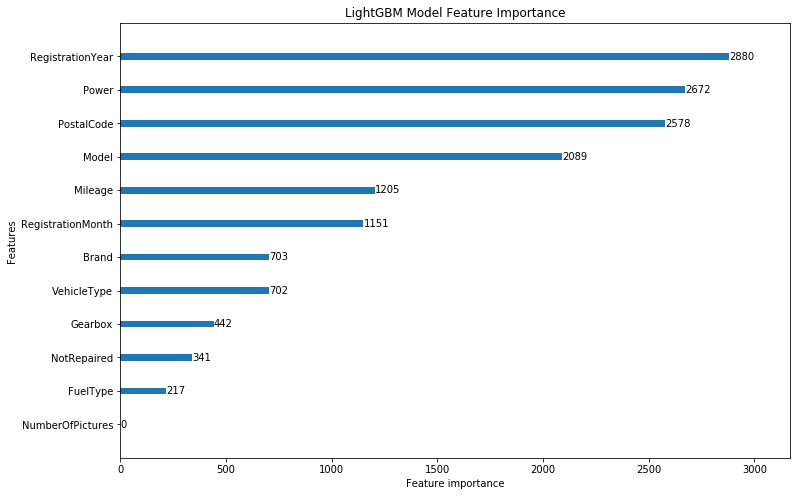

In [28]:
#Plot feature important for the final model
lgb.plot_importance(final_model, title = 'LightGBM Model Feature Importance', ignore_zero = False, grid = False, figsize = (12,8))

<a id='Overall Conclusion'></a>
## Overall Conclusion

The purpose of this project was to develop a model to determine the value of a car based on various information from a car sales ad. The model was required to balance out prediction quality, model training time, and prediction time.

The data was downloaded and preprocessed, notably OHE several categorical features for use in the various types of models. A linear regression model was trained and the quality of it was used as a baseline model to sanity check the other models. Three different gradient boosting models were evaluated: LightGBM, CatBoost, and XGBoost. Hyperparameters for each of these models were tuned and model quality, training times, and prediction times were evaluated for each.

The LightGBM model was selected for the final model due to its acceptable model quality and fast training time. The hyperparameters for the LightGBM model were even further tuned, leading to an optimal set of hyperparameters that were tested against the testing dataset for a model RMSE of 1714, a training time of 6.5s and a prediction time of 2.8s.